Time series prediction 

The particular network architecture we will employ for our RNN is known as  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.  

## 1.1 Getting started

First we must load in our time series - a history of around 140 days of Apple's stock price.  Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), but it is also commonplace to normalize by a series standard deviation.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

dataset = np.loadtxt('./datasets/apple_prices.csv')

Lets take a quick look at the time series we'll be performing predictions on.

Text(0,0.5,'series value')

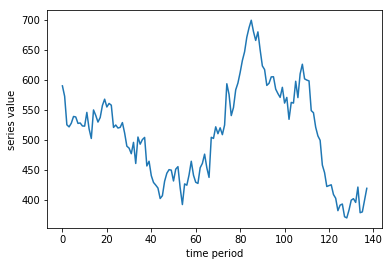

In [2]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('series value')

### TODO: Normalize time series and plot it again

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(dataset.reshape(-1, 1))

Text(0,0.5,'normalized series value')

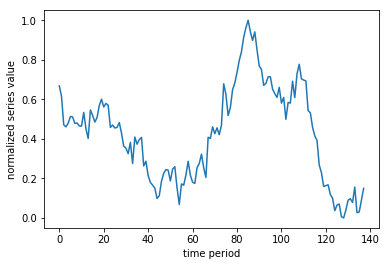

In [5]:
# lets take a look at our time series
plt.plot(scaled_dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

## 1.2  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="images\timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now its time for you to window the input time series as described above!  

<a id='TODO_1'></a>

**TODO:** Fill in the function below - called **window_transform_series** - that runs a sliding window along the input series and creates associated input/output pairs.    Note that this function should input a) the series and b) the window length, and return the input/output subsequences.  Make sure to format returned input/output as generally shown in table above (where window_size = 5), and make sure your returned input is a numpy array.

-----

In [6]:
def shift(l, n):
    return l[n:] + l[:n]

In [7]:
### TODO: fill out the function below that transforms the input series and window-size into a set of input/output pairs for use with our RNN model
def window_transform_series(series, window_size):
    n_iters = len(series) - window_size
    return np.array([series[i:i+window_size] for i in range(n_iters)]), np.array([series[i+window_size] for i in range(n_iters)]).reshape(-1,1)

You can test your function on the list of odd numbers given below

In [8]:
odd_nums = np.array([1,3,5,7,9,11,13])

# run a window of size 2 over the odd number sequence and display the results
window_size = 2
X,y = window_transform_series(odd_nums,window_size)

# print out input/output pairs --> here input = X, corresponding output = y
print ('--- the input X will look like ----')
print (X)

print ('--- the associated output y will look like ----')
print (y)

print ('the shape of X is ' + str(np.shape(X)))
print ('the shape of y is ' + str(np.shape(y)))
print('the type of X is ' + str(type(X)))
print('the type of y is ' + str(type(y)))

--- the input X will look like ----
[[ 1  3]
 [ 3  5]
 [ 5  7]
 [ 7  9]
 [ 9 11]]
--- the associated output y will look like ----
[[ 5]
 [ 7]
 [ 9]
 [11]
 [13]]
the shape of X is (5, 2)
the shape of y is (5, 1)
the type of X is <class 'numpy.ndarray'>
the type of y is <class 'numpy.ndarray'>


With this function in place apply it to the series in the Python cell below.  We use a window_size = 7 for these experiments.

In [9]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(series = scaled_dataset,window_size = window_size)

## 1.3  Splitting into training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  This is that once we train our model we have something to test it on (like any regression problem!).  This splitting into training/testing sets is done in the cell below.

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [10]:
# TODO: split our dataset into training / testing sets
train_test_split = int(2 * X.shape[0] / 3)  # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

<a id='TODO_2'></a>

## 1.4  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LTSM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

In [11]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM

Using TensorFlow backend.


In [66]:
X_train.shape, y_train.shape

((87, 7, 1), (87, 1))

In [65]:
### TODO: Implement and compile the model
model = Sequential()
model.add(LSTM(200, input_shape=(window_size, 32), activation="tanh"))
model.add(Dense(32, activation="softmax"))

In [63]:
### TODO: build model
model = Sequential()
model.add(LSTM(5, input_shape=(window_size,1), activation="tanh"))
model.add(Dense(1, activation="sigmoid"))

In [51]:
# run your model!
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mse"])

In [52]:
history=model.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
87/87 [==============================] - 1s 11ms/step - loss: 0.0524 - mean_squared_error: 0.0524
Epoch 2/1000
87/87 [==============================] - 0s 462us/step - loss: 0.0520 - mean_squared_error: 0.0520
Epoch 3/1000
87/87 [==============================] - 0s 407us/step - loss: 0.0516 - mean_squared_error: 0.0516
Epoch 4/1000
87/87 [==============================] - 0s 534us/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 5/1000
87/87 [==============================] - 0s 688us/step - loss: 0.0510 - mean_squared_error: 0.0510
Epoch 6/1000
87/87 [==============================] - 0s 580us/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 7/1000
87/87 [==============================] - 0s 474us/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 8/1000
87/87 [==============================] - 0s 449us/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 9/1000
87/87 [==============================] - 0s 535us/step - loss: 0.0496 - mean_squared_error: 

87/87 [==============================] - 0s 331us/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 146/1000
87/87 [==============================] - 0s 342us/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 147/1000
87/87 [==============================] - 0s 243us/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 148/1000
87/87 [==============================] - 0s 323us/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 149/1000
87/87 [==============================] - 0s 465us/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 150/1000
87/87 [==============================] - 0s 306us/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 151/1000
87/87 [==============================] - 0s 380us/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 152/1000
87/87 [==============================] - 0s 362us/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 153/1000
87/87 [==============================] - 0s 376us/step - loss: 0.0088 - mean_squared_err

Epoch 217/1000
87/87 [==============================] - 0s 364us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 218/1000
87/87 [==============================] - 0s 400us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 219/1000
87/87 [==============================] - 0s 417us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 220/1000
87/87 [==============================] - 0s 466us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 221/1000
87/87 [==============================] - 0s 604us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 222/1000
87/87 [==============================] - 0s 420us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 223/1000
87/87 [==============================] - 0s 458us/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 224/1000
87/87 [==============================] - 0s 440us/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 225/1000
87/87 [==============================] - 0s 443us/step - loss: 0.0080 - m

Epoch 360/1000
87/87 [==============================] - 0s 354us/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 361/1000
87/87 [==============================] - 0s 291us/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 362/1000
87/87 [==============================] - 0s 326us/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 363/1000
87/87 [==============================] - 0s 399us/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 364/1000
87/87 [==============================] - 0s 418us/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 365/1000
87/87 [==============================] - 0s 368us/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 366/1000
87/87 [==============================] - 0s 451us/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 367/1000
87/87 [==============================] - 0s 366us/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 368/1000
87/87 [==============================] - 0s 382us/step - loss: 0.0061 - m

Epoch 503/1000
87/87 [==============================] - 0s 334us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 504/1000
87/87 [==============================] - 0s 291us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 505/1000
87/87 [==============================] - 0s 322us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 506/1000
87/87 [==============================] - 0s 433us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 507/1000
87/87 [==============================] - 0s 451us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 508/1000
87/87 [==============================] - 0s 532us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 509/1000
87/87 [==============================] - 0s 337us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 510/1000
87/87 [==============================] - 0s 513us/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 511/1000
87/87 [==============================] - 0s 397us/step - loss: 0.0051 - m

Epoch 646/1000
87/87 [==============================] - 0s 293us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 647/1000
87/87 [==============================] - 0s 333us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 648/1000
87/87 [==============================] - 0s 284us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 649/1000
87/87 [==============================] - 0s 362us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 650/1000
87/87 [==============================] - 0s 370us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 651/1000
87/87 [==============================] - 0s 366us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 652/1000
87/87 [==============================] - 0s 433us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 653/1000
87/87 [==============================] - 0s 397us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 654/1000
87/87 [==============================] - 0s 373us/step - loss: 0.0048 - m

Epoch 789/1000
87/87 [==============================] - 0s 283us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 790/1000
87/87 [==============================] - 0s 325us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 791/1000
87/87 [==============================] - 0s 285us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 792/1000
87/87 [==============================] - 0s 412us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 793/1000
87/87 [==============================] - 0s 367us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 794/1000
87/87 [==============================] - 0s 429us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 795/1000
87/87 [==============================] - 0s 351us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 796/1000
87/87 [==============================] - 0s 430us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 797/1000
87/87 [==============================] - 0s 404us/step - loss: 0.0046 - m

Epoch 932/1000
87/87 [==============================] - 0s 339us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 933/1000
87/87 [==============================] - 0s 286us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 934/1000
87/87 [==============================] - 0s 412us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 935/1000
87/87 [==============================] - 0s 351us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 936/1000
87/87 [==============================] - 0s 370us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 937/1000
87/87 [==============================] - 0s 430us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 938/1000
87/87 [==============================] - 0s 376us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 939/1000
87/87 [==============================] - 0s 369us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 940/1000
87/87 [==============================] - 0s 401us/step - loss: 0.0044 - m

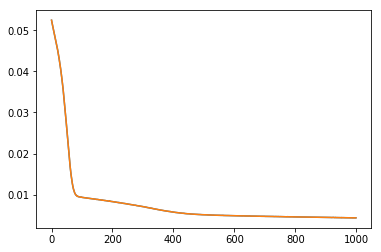

In [56]:
%matplotlib inline
plt.plot(history.history["loss"])
plt.plot(history.history["mean_squared_error"])

## 1.5  Checking model performance

With your model fit we can now make predictions on both our training and testing sets.

In [57]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In the next cell we compute training and testing errors using our trained model - you should be able to achieve at least

*training_error* < 0.02

and 

*testing_error* < 0.02

with your fully trained model.  

If either or both of your accuracies are larger than 0.02 re-train your model - increasing the number of epochs you take (a maximum of around 1,000 should do the job) and/or adjusting your batch_size.

In [58]:
X_train.shape

(87, 7, 1)

In [59]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = [0.004337271183044061, 0.004337271183044061]
testing error = [0.00587376088581302, 0.00587376088581302]


Activating the next cell plots the original data, as well as both predictions on the training and testing sets. 

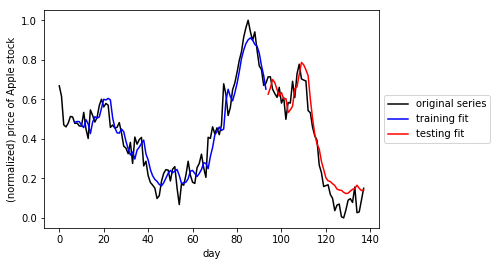

In [60]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(scaled_dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Note:** you can try out any time series for this exercise!  If you would like to try another see e.g., [this site containing thousands of time series](https://datamarket.com/data/list/?q=provider%3Atsdl) and pick another one!